In [29]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

## まとめ
- 単語の意味をコンピュータに理解させるためにはどうすればいいか？
    - シソーラス
        - 人の手で一つずつ単語の関連性を定義
        - 手間がかかり，表現力に限界がある
    - カウントベース
        - 単語の意味は周囲の単語によって形成される，という「分布仮説」に基づく手法
        - コーパスから自動的に単語の意味を（類似度を測定できる行列として）抽出
        - 単語をベクトルで表現

カウントベースの手法の手順
- コーパスから単語の共起行列を作成
- 共起行列を正の相互情報量を計算することでPPMI行列に変換
- SVDによる次元削減によって，計算量とロバスト性の問題を解消し，PPMIの単語ベクトルを密なベクトルへ変換

カウントベースの手法によって，意味的にも，文法的にも近い単語はベクトル空間上で近い位置になる．

テキストデータを扱いやすくするための下準備の関数を実装
- cos_similarity(): ベクトル同士のコサイン類似度
- most_similar(): PPMI行列から類似単語のランキングを表示

コンピュータに言葉を理解させるとはどういうことか？  
そのアプローチはどんなものがあるのか？  
テキストをPythonで扱う練習  
ここで実装するものは他の章でも使う

# 自然言語処理とは
私たちの言葉をコンピュータに理解させるための技術分野  
柔らかい自然言語の特徴
- 文章に曖昧さがある
- 同じ意味の文章でも様々な表現が可能
- 時代とともに新しい言葉や新しい意味が生まれたり，廃れたりする
応用先
- 検索エンジン
- 機械翻訳
- 質問回答システム(Watsonなど)
- IME(かな漢字変換)
- 自動要約
- 感情分析  

Watsonは，膨大な医療データを活用して，難病患者の正しい治療法を提案し，患者の命を救った事例が報告されている．  

## 単語の意味
単語は意味の最小単位  
自然言語をコンピュータに理解させるためには単語の意味を理解させることが重要  
単語の意味をうまく捉えた表現方法をいくつか考えていく

- シソーラス(類語辞書)による手法
- カウントベースによる手法(統計情報から単語を表現する手法)
- 推論ベースによる手法(word2vec, 次章)

本章の構成はスタンフォード大学の授業「CS224d:Deep Learning for Natural Language Processing」を参考にしている．

## シソーラス
辞書：単語の意味を文章で定義する．例：自動車 = 車輪を取り付けた乗り物や運搬具…  
類語辞書(シソーラス，thesaurus)：意味の似た単語が同じグループに分類されている．例：car = auto, automobile, machine. motocar
上位概念，下位概念が定義されているシソーラスもある．例：carはmotor vehicleの下位概念  

### Wordnet
プリンストン大学で1985から開発されているシソーラス  
付録BでNLTKモジュールでWordNetを使った単語間類似度測定の実験を行う．  
単語の類似度を求めることは，単語の意味理解への第一歩

### シソーラスの問題点
- 時代の変化に対応するのが困難
- 人の作業コストが高い（現存単語1000万に対し，WordNetは20万単語に対応)
- 単語の細かなニュアンスを表現できない．例：ヴィンテージとレトロの違い

## カウントベースの手法
コーパス：研究やアプリケーションのため，特定の目的を持って集められたテキストデータのあつまり  
コーパスは人の手によって書かれたテキストデータなので自然言語に対する人の知識が含まれている  
コーパスには，単語に品詞などのラベルづけがされていることがある．  

### Pythonによるコーパスの下準備
WikipediaやGoogle Newsなど，様々なコーパスが存在する．  
ここではまず1文からなるテキストをコーパスとして利用する．  

In [5]:
text = 'You say goodbye and I say hello.'

text = text.lower()
text = text.replace('.', ' .')
print(text)

words = text.split(' ')
print(words)

# 正規表現を使ってもいい

you say goodbye and i say hello .
['you', 'say', 'goodbye', 'and', 'i', 'say', 'hello', '.']


In [11]:
# 単語にIDをつける
word_to_id = {}
id_to_word = {}

for word in words:
    if word not in word_to_id:
        new_id = len(word_to_id)
        word_to_id[word] = new_id
        id_to_word[new_id] = word

print(word_to_id)
print(id_to_word)

print()

print(id_to_word[1])
print(word_to_id['hello'])

print()

# コーパスを単語IDに変換
corpus = [word_to_id[w] for w in words]
corpus = np.array(corpus)
print(corpus)

{'you': 0, 'say': 1, 'goodbye': 2, 'and': 3, 'i': 4, 'hello': 5, '.': 6}
{0: 'you', 1: 'say', 2: 'goodbye', 3: 'and', 4: 'i', 5: 'hello', 6: '.'}

say
5

[0 1 2 3 4 1 5 6]


コーパスの下準備用の関数を作成しておく

In [7]:
def preprocess(text):
    text = text.lower()
    text = text.replace('.', ' .')
    words = text.split(' ')
    
    word_to_id = {}
    id_to_word = {}
    for word in words:
        if word not in word_to_id:
            new_id = len(word_to_id)
            word_to_id[word] = new_id
            id_to_word[new_id] = word
    
    corpus = np.array([word_to_id[w] for w in words])
    return corpus, word_to_id, id_to_word

In [8]:
text = 'You say goodbye and I say hello.'
corpus, word_to_id, id_to_word = preprocess(text)
print(corpus, '\n', word_to_id, '\n', id_to_word)

[0 1 2 3 4 1 5 6] 
 {'you': 0, 'say': 1, 'goodbye': 2, 'and': 3, 'i': 4, 'hello': 5, '.': 6} 
 {0: 'you', 1: 'say', 2: 'goodbye', 3: 'and', 4: 'i', 5: 'hello', 6: '.'}


### 単語の分散表現
色は「深緋」と名前をつける他にも，(201,23,30)とベクトルで表現することができる．  
単語もベクトルで表せないだろうか？  
単語の意味を的確に捉えたベクトル表現のことを，単語の分散表現と呼ぶ

### 分布仮説
分布仮説：単語の意味は，周囲の単語によって形成される  
単語自体には意味がなく，単語のコンテキスト（文脈）によって単語の意味が形成される  
たとえば，「drink」の近くには，飲み物の名前が現れやすい  
We guzzle wineのような文章は，guzzle(がぶがぶ飲む)がdrinkに似た文脈で使われることがわかる．  
この先，「コンテキスト」は「周囲に存在する単語」を指す．  
周囲(前後)の単語をどれだけ含めるかということを「ウィンドウサイズ」という言葉で表す．  
ウィンドウサイズが1の場合は左右の1単語を含める．  
本書では単純さを優先して，文の区切りを考慮せず，左右均等のコンテキストのみを扱う．

### 共起行列
たとえば，You say goodbye and I say hello.のyouのコンテキストにはsayがひとつだけ存在する．  
この場合，youに関するテーブルは次のようになる  

|単語|you|say|goodbye|and|i|hello|.|
|-:-|-:-|-:-|-:-|-:-|-:-|-:-|-:-|
|you|0|1|0|0|0|0|0|0|

これを全ての単語について行なった行列を共起行列(co-occurence matrix)と呼ぶ．  
このように共起行列を用いて単語をベクトルで表す手法を「カウントベースの手法」「統計的手法」と呼ぶ

In [9]:
def create_co_matrix(corpus, vocab_size, window_size=1):
    corpus_size = len(corpus)
    co_matrix = np.zeros((vocab_size, vocab_size), dtype=np.int32)
    
    for idx, word_id in enumerate(corpus):
        for i in range(1, window_size + 1):
            left_idx = idx - i
            right_idx = idx + i
            
            if left_idx >= 0:
                left_word_id = corpus[left_idx]
                co_matrix[word_id, left_word_id] += 1
            
            if right_idx < corpus_size:
                right_word_id = corpus[right_idx]
                co_matrix[word_id, right_word_id] += 1
    
    return co_matrix

In [16]:
text = 'You say goodbye and I say hello.'
corpus, word_to_id, id_to_word = preprocess(text)
co_matrix = create_co_matrix(corpus, vocab_size=len(word_to_id), window_size=1)
print(co_matrix)

[[0 1 0 0 0 0 0]
 [1 0 1 0 1 1 0]
 [0 1 0 1 0 0 0]
 [0 0 1 0 1 0 0]
 [0 1 0 1 0 0 0]
 [0 1 0 0 0 0 1]
 [0 0 0 0 0 1 0]]


### ベクトル間の類似度
ここでは，コサイン類似度を取り上げる  
2つのベクトル$x = (x_1, x_2, ... x_n)$ と $y = (y_1, y_2, ..., y_n)$のコサイン類似度は  
$$ similarity(x, y) = \frac{x \cdot y}{\|x\|\|y\|} $$
コサイン類似度は，直感的には「2つのベクトルがどれだけ同じ方向を向いているか」を表す．  
2つのベクトルが完全に同じ方向を向いている時＋1，完全に逆向きだと-1になる．  

In [14]:
def cos_simirality(x, y, eps=1e-8):
    nx = x / np.sqrt(np.sum(x**2) + eps)
    ny = y / np.sqrt(np.sum(y**2) + eps)
    return nx @ ny

epsはゼロ除算を防ぐため

youとiの類似度を求めてみる

In [17]:
c0 = co_matrix[word_to_id['you']]
c1 = co_matrix[word_to_id['i']]
print(cos_simirality(c0, c1))

0.7071067758832467


### 類似単語のランキング表示
ある単語がクエリとして与えられた時に，そのクエリに対して類似した単語を上位から順に表示する関数  

In [19]:
def most_similar(query, word_to_id, id_to_word, word_matrix, top=5):
    if query not in word_to_id:
        print('%s is not found' % query)
        return
    
    print('\n[query] ' + query)
    query_id = word_to_id[query]
    query_vec = word_matrix[query_id]
    
    vocab_size = len(id_to_word)
    similarity = np.zeros(vocab_size)
    for i in range(vocab_size):
        similarity[i] = cos_simirality(word_matrix[i], query_vec)
    
    count = 0
    for i in (-1 * similarity).argsort():
        if id_to_word[i] == query:
            continue
        print(' %s: %s' % (id_to_word[i], similarity[i]))
        
        count += 1
        if count >= top:
            return

def most_similar_by_text(query, text, window_size=1, top=5):
    corpus, word_to_id, id_to_word = preprocess(text)
    word_matrix = create_co_matrix(corpus, vocab_size=len(word_to_id), window_size=window_size)
    return most_similar(query, word_to_id, id_to_word, word_matrix, top)

In [20]:
text = 'You say goodbye and I say hello.'
most_similar_by_text('you', text)


[query] you
 goodbye: 0.7071067758832467
 i: 0.7071067758832467
 hello: 0.7071067758832467
 say: 0.0
 and: 0.0


この結果は我々の感覚とズレがあるが，あとでもっと大きなコーパスで同じ実験を行う．

## カウントベースの手法の改善

### 相互情報量
「drive the car」というテキストでは，carはdriveよりもtheに関連性が強くなってしまう．  
この問題を解決するために相互情報量を用いる．  
確率変数$x$, $y$に対し，
$$ PMI(x, y) = log_2 \frac{P(x,y)}{P(x)P(y)} $$
PMI(Pointwise Mutual Information)は，値が大きいほど2つの確率変数の関連が強いことを意味する．  
さらに，コーパスに含まれる単語を$N$，単語$x$がコーパスに出現する回数を$C(x)$とすると，PMIは以下のように変形できる．
$$ PMI(x, y) = log_2 \frac{P(x,y)}{P(x)P(y)}=\frac{\frac{C(x,y)}{N}}{\frac{C(x)}{N} \frac{C(y)}{N}} = log_2 \frac{C(x,y)\cdot N}{C(x)C(y)} $$
  
例えばあるコーパスが，
- 総単語: 10000
- the: 1000回
- car: 20回
- drive: 10回
- theとcarの共起: 10回
- carとdriveの共起: 5回  

だった場合，
$$ PMI("the", "car") = log_2 \frac{10\cdot10000}{1000\cdot20} \simeq 2.32 $$
$$ PMI("drive", "car") = log_2 \frac{5\cdot10000}{20\cdot10} \simeq 7.97 $$
となり，我々の望む結果が得られる．  
このような結果になるのは，「theが多ければそりゃあcarとの共起回数も増えるよね，回数が多い単語にはペナルティを課そう」  
という感覚が式に含まれてるから．

しかし，共起回数が0だった場合，
$$ log_2 0 = - \infty $$
となってしまう．これに対応するため，正の相互情報量(Positive PMI)を
$$ PPMI(x,y) = max(0, PMI(x, y))$$
と定義する．

In [23]:
# 共起行列Cに対する正の相互情報量を行列で返す
# verboseによって進行度を確認
# epsによってnp.log2(0)=-infを避ける
def ppmi(C, verbose=False, eps=1e-8):
    M = np.zeros_like(C, dtype=np.float32)
    N = np.sum(C)
    S = np.sum(C, axis=0)
    total = C.shape[0] * C.shape[1]
    cnt = 0
    
    for i in range(C.shape[0]):
        for j in range(C.shape[1]):
            pmi = np.log2(C[i, j] * N / (S[j]*S[i]) + eps)
            M[i, j] = max(0, pmi)
            
            if verbose:
                cnt += 1
                if cnt % (total // 100) == 0:
                    print('%.1f%% done' % (100 * cnt / total))
    
    return M

In [26]:
W = ppmi(co_matrix)
print(W)

[[0.        1.8073549 0.        0.        0.        0.        0.       ]
 [1.8073549 0.        0.8073549 0.        0.8073549 0.8073549 0.       ]
 [0.        0.8073549 0.        1.8073549 0.        0.        0.       ]
 [0.        0.        1.8073549 0.        1.8073549 0.        0.       ]
 [0.        0.8073549 0.        1.8073549 0.        0.        0.       ]
 [0.        0.8073549 0.        0.        0.        0.        2.807355 ]
 [0.        0.        0.        0.        0.        2.807355  0.       ]]


PPMI行列の問題点
- コーパスの語彙数が10万に達すれば，10万次元のベクトルを扱うことになり，非効率
- 0の要素が多いためムダが多い
    - ノイズに弱く，頑健性に乏しい

### 次元削減
上記の問題点の解決策の一つ  
重要な情報をできるだけ残した上でベクトルの次元を削減する  
データの分布から重要な軸を見つける  
斜め方向に分布している2次元の点集合を，その斜め線に沿った軸を新たな次元とし，その軸からの距離を新たなデータとする．  
これによって，疎なベクトルを密なベクトルに変換する

次元削減を行う方法の一つに特異値分解(Singular Vaue Decomposition, SVD)がある．  
SVDは以下のように，任意の行列を3つの行列の席に分割する．  
$$ X = USV^{^\top} $$
ここで，UとVは直交行列(転置した自分をかけると単位行列)で，互いに直行する．  
Sは対角行列で，対角成分以外は全て0．ただしSは正方行列でないこともあり，その場合は下部が全て0になる  
Uは何らかの空間の軸（基底）を形成しており，「単語空間」として扱える．  
Sは対角行列で，この対角成分には特異値というものが大きい順に並んでいる．  
特異値とは，対応する軸の重要度とみなすことができる．  

行列Uから行列Sの特異値が低いところに対応する軸を取り除き，U'とすることで，元の行列を近似できる．  
同時に，SをS'，VをV'とすることで，
$$ X \simeq U'S'V'^{\top} $$
と近似できる．  

ここで，Xを単語IDの単語ベクトル，それらの単語ベクトルが行列U'として次元削減されたベクトルで表現される．  

SVDのオーダーは行列のサイズをNとすると$O(N^3)$  
これは重いため，Truncated SVDという特異値の小さなものを切り捨てることで高速化を行う方法がある．  
Truncated SVDはsklearnライブラリに含まれており，次節で利用する．

ここではこれ以上数学的な詳細には踏み入らない．

[0 1 0 0 0 0 0]
[0.        1.8073549 0.        0.        0.        0.        0.       ]
[ 3.4094876e-01  0.0000000e+00 -1.2051624e-01 -3.8857806e-16
 -9.3232495e-01 -1.1102230e-16 -2.4257469e-17]
[0.34094876 0.        ]


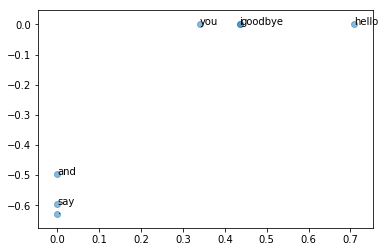

In [36]:
# numpyのlinalgモジュールにあるsvdによって簡単に特異値分解できる
U, S, V = np.linalg.svd(W)

print(co_matrix[0])
print(W[0]) # 元は疎だったWが
print(U[0]) # 密なベクトルに

print(U[0, :2]) # 先頭2つの要素を取り出して次元削減  

# 各単語を2次元ベクトルで表す
for word, word_id in word_to_id.items():
    # 2次元ベクトルで表した各点の位置にアノテーション（単語テキスト）を配置
    plt.annotate(word, (U[word_id, 0], U[word_id, 1]))

# Uの(全行, 0列)と(全行, 1列)を使って2次元に次元削減
plt.scatter(U[:,0], U[:,1], alpha=0.5)
plt.show()

この図から，goodbyeとhello，youとiが近い場所に位置することがわかる．  

### PTBデータセット
Penn Treebankデータセット  
本格的だが大きすぎない手頃なコーパス  
ベンチマークとしてもよく利用される  

PTBデータセットは，いくつかの前処理が行われている．  
- レアな単語を< unk >という特殊文字で置き換える
- 具体的な数字をNで置き換える
- 各文の終わりに，end of sentence < eos > という特殊文字が挿入される．

本書では，文の区切りを考慮せずに，複数の文を連結したものを「一つの大きな時系列データ」とみなす．  
文単位で処理すること，文単位で単語の頻度をカウントすることも可能だが，簡単のため文ごとの処理は行わない．

In [39]:
from dataset import ptb
corpus, word_to_id, id_to_word = ptb.load_data('train')

print('corpus size:', len(corpus))
print('corpus[:30]', corpus[:30])
print()
print('id_to_word[0]', id_to_word[0])
print('id_to_word[1]', id_to_word[1])
print('id_to_word[2]', id_to_word[2])
print()
print("word_to_id['car']", word_to_id['car'])
print("word_to_id['happy']", word_to_id['happy'])
print("word_to_id['lexus']", word_to_id['lexus'])

URLError: <urlopen error [Errno 8] nodename nor servname provided, or not known>

### PTBデータセットでの評価
truncated SVDを使う場合は乱数を使う関係で結果が毎回異なる

In [ ]:
window_size = 2
wordvec_size = 100 # 100次元に削減

corpus, word_to_id, id_to_word = ptb.load_data('train')
vocab_size = len(word_to_id)
print('counting co-occurence ...')
C = create_to_matrix(corpus, vocab_size, window_size)
print('calculating PPMI')
W = ppmi(C, verbose=True)

print('calculating SVD ...')
try: 
    # truncated SVD(fast!)
    from sklearn.utils.extmath import randomized_svd
    U, S, V = randmized_svd(W, n_components=wordvec_size, n_iter=5, random_state=None)
except ImportError:
    # SVD (slow)
    U, S, V = np.linalg.svd(W)

word_vecs = U[:, :wordvec_size]
querys = ['you', 'year', 'car', 'toyota']
for query in querys:
    most_similar(query, word_to_id, id_to_word, word_vecs, top=5)

いい感じに類似した単語を抽出してくれている  
すなわち，単語の意味をベクトルにうまくエンコードすることに成功した．  
ここまでの手順は以下のようになっている．
- コーパスを用意
- コンテキストの単語をカウントして，共起行列を作成
- 共起行列を単語同士の類似度を正の相互情報量で表したPPMI行列に変換
- PPMI行列をSVDによって次元削減（これが求める単語の分散表現，各単語が固定長の密なベクトルで表現された．）
- クエリとしての単語に似ている単語をコーパスから抽出

さらに大規模なコーパスを使用すれば，より優れた単語の分散表現が生成されることが期待できる．